In [36]:
import librosa
import numpy as np

sample_rate = 22050
def extract_features(file_path):
    audio, sample = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

    combined_features = np.hstack([mfccs, chroma, spectral_contrast])

    return combined_features

In [37]:
import os
import pandas as pd

data = {}
paras = []
labels = []
base_path = "data/voices"

for label in os.listdir(base_path):
    folder_path = os.path.join(base_path, label)
    for f in os.listdir(folder_path):
        file_path = os.path.join(folder_path, f)
        try:
            features = extract_features(file_path)
            paras.append(features)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

data.update({'para': paras})
data.update({'label': labels})

df = pd.DataFrame(data)
print(df)
df.to_csv("emotion_dataset.csv", index=False)


                                                  para    label
0    [-633.8720092773438, 67.79197692871094, -5.010...  neutral
1    [-663.0482788085938, 55.50645446777344, -14.49...  neutral
2    [-625.6010131835938, 65.5589828491211, 3.51763...  neutral
3    [-721.6300048828125, 49.79100036621094, -9.977...  neutral
4    [-598.2384643554688, 62.16184616088867, -1.875...  neutral
..                                                 ...      ...
214  [-521.1227416992188, 77.6032485961914, -10.188...    angry
215  [-466.6045837402344, 29.697959899902344, -30.5...    angry
216  [-353.06134033203125, 52.146942138671875, -18....    angry
217  [-523.342529296875, 27.337602615356445, -22.06...    angry
218  [-503.56573486328125, 45.8590087890625, -4.600...    angry

[219 rows x 2 columns]


In [78]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("emotion_dataset.csv")

df_temp = []
for i in df['para']:
    frame = [ float(num) for num in (i.strip('[]').split())]
    df_temp.append(frame)
df['para'] = df_temp

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

x = np.vstack(df['para']) #features
y = df['label'].values #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', k_neighbors=10) #Reduce over-sampling dataset
x_res, y_res = smote.fit_resample(x_train, y_train)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=1, leaf_size=1, algorithm='ball_tree', metric='manhattan', weights='distance'))
])


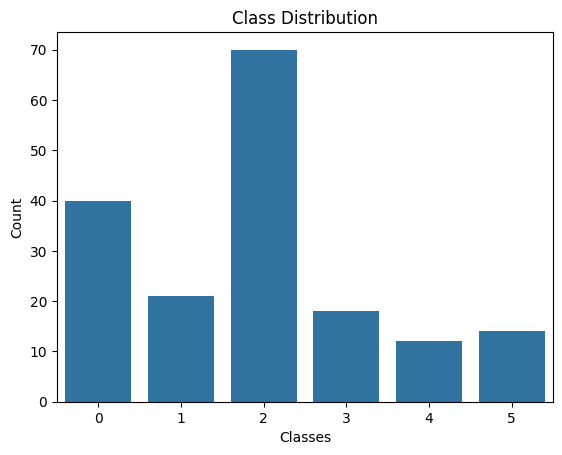

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

Model knn_emotion_recognition.pkl not found.
True Accuracy:  72.73%
Mean CV Accuracy: 92.62%
CV Accuracy Standard Deviation: 1.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.89      1.00      0.94         8
           2       0.67      0.83      0.74        12
           3       0.67      0.67      0.67         3
           4       0.60      0.50      0.55         6
           5       0.50      0.50      0.50         4

    accuracy                           0.73        44
   macro avg       0.70      0.69      0.69        44
weighted avg       0.73      0.73      0.72        44



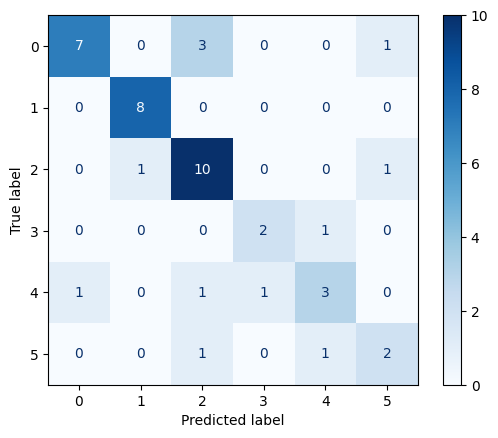

In [79]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib

file_name = "knn_emotion_recognition.pkl"
if os.path.isfile(file_name):
    knn_model = joblib.load(file_name)
    print(f"{file_name} model loaded.")
else:
    knn_model = pipeline
    print(f"Model {file_name} not found.")

knn_model.fit(x_res, y_res)

y_pred = knn_model.predict(x_test)

scores = cross_val_score(knn_model, x_res, y_res, cv=10)  # 5-fold cross-validation

accuracy = accuracy_score(y_test, y_pred)
print(f"True Accuracy: {accuracy * 100: .2f}%")
print(f"Mean CV Accuracy: {scores.mean() * 100:.2f}%")
print(f"CV Accuracy Standard Deviation: {scores.std() * 100:.2f}%")

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'leaf_size': [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=30, scoring='accuracy')
grid_search.fit(x_res, y_res)

print(f"Best Parameters: {grid_search.best_params_}")
best_knn_model = grid_search.best_estimator_

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x and y are your data features and labels
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

# Create a mesh grid with a larger step size for reduced memory usage
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.2),  # Larger step size
    np.arange(y_min, y_max, 0.2)
)

# Create the grid points for prediction (59 features: first 2 from grid, others as mean)
grid_points = np.c_[xx.ravel(), yy.ravel()]  # (N, 2)
default_features = np.mean(x, axis=0)[2:]  # Mean values for remaining 57 features
grid_points_full = np.hstack([grid_points, np.tile(default_features, (grid_points.shape[0], 1))])

# Batch prediction to avoid memory overload
batch_size = 5000  # Number of points per batch
Z = np.zeros(grid_points_full.shape[0])  # Initialize Z with correct size
for i in range(0, grid_points_full.shape[0], batch_size):
    batch_points = grid_points_full[i:i + batch_size]
    Z_batch = knn_model.predict(batch_points)
    Z[i:i + batch_size] = Z_batch

# Reshape Z to match the grid (xx and yy shape)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.title('k-NN Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


: 

In [142]:
import joblib

joblib.dump(best_knn_model, "knn_emotion_recognition.pkl")

['knn_emotion_recognition.pkl']

In [ ]:
loaded_model = joblib.load("knn_emotion_recognition.pkl")

In [ ]:
file_path = ""
features = extract_features(file_path).reshape(1, -1)

predicted_label = loaded_model.predict(features)
emotion = label_encoder.inverse_transform(predicted_label)
print(f"Predicted Result: {emotion}")